# 새로운 시작

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/open/

## 데이터 로딩 및 전처리

### Subtask:
이전 셀의 코드를 사용하여 데이터를 로드하고 전처리합니다. 범주형/수치형 컬럼을 사용자 요구사항에 맞게 재정의하고, 각 컬럼 타입에 맞는 스케일링 및 인코딩을 적용합니다. `seq` 컬럼은 문자열 그대로 유지합니다.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

all_train = pd.read_parquet("./train-001.parquet", engine="pyarrow")
test = pd.read_parquet("./test.parquet", engine="pyarrow").drop(columns=['ID'])

In [2]:

train_df = all_train.sample(frac=1, random_state=42).reset_index(drop=True)

target_col = "clicked"
seq_col = "seq"

categorical_cols = ['gender', 'age_group', 'inventory_id', 'day_of_week', 'hour']
categorical_cols.extend([c for c in train_df.columns if c.startswith('l_feat_') and c not in categorical_cols])

numerical_cols = [c for c in train_df.columns if (c.startswith('feat_') or c.startswith('history_')) and c not in categorical_cols and c != seq_col and c != target_col and c != 'ID']

all_defined_cols = set(categorical_cols + numerical_cols + [seq_col, target_col, 'ID'])
remaining_cols = [c for c in train_df.columns if c not in all_defined_cols]


vocab_sizes = {}
for col in categorical_cols:
    all_categories = pd.concat([all_train[col], test[col]]).astype(str).unique()
    vocab_sizes[col] = len(all_categories) + 1
    le = LabelEncoder()
    le.fit(all_categories)
    train_df[col] = le.transform(train_df[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
    train_df[col] = train_df[col].astype(int)
    test[col] = test[col].astype(int)

scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols]).astype(float)
test[numerical_cols] = scaler.transform(test[numerical_cols]).astype(float)

In [3]:

import numpy as np
import pandas as pd
import torch

def debug_dataset(train_df, categorical_cols, vocab_sizes, embedding_dims, transformer_heads):
    numeric_df = train_df.select_dtypes(include=[np.number])
    nan_counts = numeric_df.isna().sum()
    nan_cols = nan_counts[nan_counts > 0]

    inf_mask = np.isinf(numeric_df.to_numpy())

    for col in categorical_cols:
        max_val = train_df[col].max()
        min_val = train_df[col].min()
        vocab_size = vocab_sizes[col]

    total_emb_dim = sum(embedding_dims[col] for col in categorical_cols)
    if total_emb_dim % transformer_heads != 0:
        pass

    if "seq" in train_df.columns:
        zero_seq_count = (train_df["seq"] == 0).sum()

    for col in categorical_cols:
        max_idx = train_df[col].max()
        min_idx = train_df[col].min()

embedding_dims = {col: 16 for col in categorical_cols}
debug_dataset(
    train_df=train_df,
    categorical_cols=categorical_cols,
    vocab_sizes=vocab_sizes,
    embedding_dims=embedding_dims,
    transformer_heads=4
)

import numpy as np
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
train_df[numeric_cols] = (
    train_df[numeric_cols]
    .fillna(0)
    .replace([np.inf, -np.inf], 0)
)

## Dataset 및 DataLoader 수정

### Subtask:
새로운 모델 구조에 맞게 `ClickDataset` 클래스를 수정하거나 새로 정의합니다. 특히 `seq` 데이터를 시퀀스 형태로 처리하고, 다른 피처들을 분리하여 반환하도록 합니다. Collate 함수도 수정하여 `seq` 데이터 패딩 및 길이를 처리합니다.

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
import numpy as np
import pandas as pd

class ClickDataset(Dataset):
    def __init__(self, df, categorical_cols, numerical_cols, seq_col, target_col=None, has_target=True):
        self.df = df.reset_index(drop=True)
        self.categorical_cols = categorical_cols
        self.numerical_cols = numerical_cols
        self.seq_col = seq_col
        self.target_col = target_col
        self.has_target = has_target

        if self.has_target:
            self.y = self.df[self.target_col].astype(np.float32).values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cat_features = torch.tensor(self.df.loc[idx, self.categorical_cols].values.astype(int), dtype=torch.long)
        num_features = torch.tensor(self.df.loc[idx, self.numerical_cols].values.astype(float), dtype=torch.float)


        seq_string = self.df.loc[idx, self.seq_col]
        if isinstance(seq_string, str) and seq_string:
            try:
                seq_array = np.fromstring(seq_string, sep=",", dtype=np.float32)
            except ValueError:
                seq_array = np.array([0.0], dtype=np.float32)
        else:
            seq_array = np.array([0.0], dtype=np.float32)

        seq_tensor = torch.from_numpy(seq_array)

        if self.has_target:
            y = torch.tensor(self.y[idx], dtype=torch.float)
            return cat_features, num_features, seq_tensor, y
        else:
            return cat_features, num_features, seq_tensor

def collate_fn_train(batch):
    cat_features, num_features, seqs, ys = zip(*batch)

    cat_features = torch.stack(cat_features)
    num_features = torch.stack(num_features)
    ys = torch.stack(ys).unsqueeze(1)

    seqs_padded = rnn_utils.pad_sequence(seqs, batch_first=True, padding_value=0.0)
    seq_lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    seq_lengths = torch.clamp(seq_lengths, min=1)

    return cat_features, num_features, seqs_padded, seq_lengths, ys

def collate_fn_infer(batch):
    cat_features, num_features, seqs = zip(*batch)

    cat_features = torch.stack(cat_features)
    num_features = torch.stack(num_features)

    seqs_padded = rnn_utils.pad_sequence(seqs, batch_first=True, padding_value=0.0)
    seq_lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    seq_lengths = torch.clamp(seq_lengths, min=1)

    return cat_features, num_features, seqs_padded, seq_lengths

## 모델 구조 정의

### Subtask:
사용자 요구사항에 맞춰 새로운 `ComplexModel` 클래스를 정의합니다. 이 클래스 안에는 다음 서브 모듈이 포함됩니다.
- 범주형 피처를 위한 임베딩 레이어와 Transformer Encoder.
- 시퀀스 데이터 처리를 위한 LSTM.
- `feat_*_*` 수치형 피처를 위한 MLP.
- `history_*_*` 수치형 피처를 위한 MLP.
- 모든 서브 모듈의 출력을 결합하고 최종 예측을 수행하는 MLP.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.metrics import average_precision_score
class ModifiedModel(nn.Module):
    def __init__(self, vocab_sizes, embedding_dims, numerical_dim, lstm_hidden_dim=64,
                 lstm_n_layers=2, transformer_heads=4, transformer_layers=2, dropout=0.2):
        super().__init__()

        self.embedding_layers = nn.ModuleDict({col: nn.Embedding(vocab_sizes[col], embedding_dims[col])
                                               for col in vocab_sizes.keys()})
        total_categorical_embedding_dim = sum(emb.embedding_dim for emb in self.embedding_layers.values())

        self.num_norm = nn.BatchNorm1d(numerical_dim)

        self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hidden_dim, num_layers=lstm_n_layers, batch_first=True)

        transformer_d_model = total_categorical_embedding_dim + lstm_hidden_dim + numerical_dim

        # Ensure transformer_d_model is divisible by transformer_heads
        if transformer_d_model % transformer_heads != 0:
             # Adjust transformer_d_model to be divisible
             print(f"Warning:{transformer_d_model}%{transformer_heads}!=0")
             transformer_d_model = (transformer_d_model // transformer_heads) * transformer_heads
             print(f"Warning: Adjusted transformer_d_model to {transformer_d_model} to be divisible by {transformer_heads}")


        encoder_layer = TransformerEncoderLayer(d_model=transformer_d_model, nhead=transformer_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        final_mlp_input_dim = transformer_d_model
        self.final_mlp = nn.Sequential(
            nn.Linear(final_mlp_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),  # Added hidden layer
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128), # Added hidden layer
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, cat_x, num_x, seq_x, seq_lengths):
        embeddings = [self.embedding_layers[col](cat_x[:, i]) for i, col in enumerate(categorical_cols)]
        cat_embedded = torch.cat(embeddings, dim=1)
        #print(f"cat_embedded shape: {cat_embedded.shape}")

        num_x = self.num_norm(num_x)
        #print(f"num_x shape: {num_x.shape}")


        seq_x = seq_x.unsqueeze(-1)
        packed_seq = nn.utils.rnn.pack_padded_sequence(seq_x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed_seq)
        lstm_output = h_n[-1]
        #print(f"lstm_output shape: {lstm_output.shape}")


        combined_features = torch.cat([cat_embedded, num_x, lstm_output], dim=1)
        #print(f"combined_features shape before adjustment: {combined_features.shape}")


        # Pad or truncate combined_features to match the adjusted transformer_d_model
        target_dim = self.transformer_encoder.layers[0].self_attn.embed_dim
        if combined_features.size(1) != target_dim:
             # Create a new tensor with the correct size and copy the data
             adjusted_combined_features = torch.zeros(combined_features.size(0), target_dim, device=combined_features.device)
             copy_size = min(combined_features.size(1), adjusted_combined_features.size(1))
             adjusted_combined_features[:, :copy_size] = combined_features[:, :copy_size]
             combined_features = adjusted_combined_features
             #print(f"combined_features shape after adjustment: {combined_features.shape}")


        transformer_output = self.transformer_encoder(combined_features.unsqueeze(1)).squeeze(1)
        #print(f"transformer_output shape: {transformer_output.shape}")


        logits = self.final_mlp(transformer_output).squeeze(1)
        return logits




def calculate_weighted_logloss(y_true, y_pred, eps=1e-15):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    mask_0 = (y_true == 0)
    mask_1 = (y_true == 1)
    ll_0 = -np.mean(np.log(1 - y_pred[mask_0])) if mask_0.sum() > 0 else 0
    ll_1 = -np.mean(np.log(y_pred[mask_1])) if mask_1.sum() > 0 else 0
    return 0.5 * ll_0 + 0.5 * ll_1

def calculate_competition_score(y_true, y_pred):
    ap = average_precision_score(y_true, y_pred)
    wll = calculate_weighted_logloss(y_true, y_pred)
    score = 0.5 * ap + 0.5 * (1 / (1 + wll))
    return score, ap, wll

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts # Import the new scheduler

def train_complex_model(train_df, categorical_cols, numerical_cols, seq_col, target_col,
                         vocab_sizes, embedding_dims, lstm_hidden_dims=64, lstm_layers=2, transformer_n_heads=4, transformer_n_layers=2,
                         n_dropout=0.2, batch_size=512, epochs=3, lr=1e-3, device="cuda"):

    tr_df, va_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

    train_dataset = ClickDataset(tr_df, categorical_cols, numerical_cols, seq_col, target_col, has_target=True)
    val_dataset = ClickDataset(va_df, categorical_cols, numerical_cols, seq_col, target_col, has_target=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_train, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_train, num_workers=2)

    numerical_dim = len(numerical_cols)

    model = ModifiedModel(
        vocab_sizes=vocab_sizes,
        embedding_dims=embedding_dims,
        numerical_dim=numerical_dim,
        lstm_hidden_dim=lstm_hidden_dims,
        lstm_n_layers=lstm_layers,
        transformer_heads=transformer_n_heads,
        transformer_layers=transformer_n_layers,
        dropout=n_dropout
    ).to(device)

    pos_count = tr_df[target_col].sum()
    neg_count = len(tr_df) - pos_count
    pos_weight = torch.tensor(neg_count / pos_count, dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # Replace CosineAnnealingLR with CosineAnnealingWarmRestarts
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=2)


    train_losses = []
    val_losses = []
    train_ap_scores = []
    val_ap_scores = []
    train_wll_scores = []
    val_wll_scores = []
    train_comp_scores = []
    val_comp_scores = []

    best_val_comp_score = -float('inf')
    best_model_state_dict = None
    model_save_path = './T2G_simple_best_model.pth'

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_true = []
        for cat_features, num_features, seqs_padded, seq_lengths, ys in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
            cat_features, num_features, seqs_padded, seq_lengths, ys = cat_features.to(device), num_features.to(device), seqs_padded.to(device), seq_lengths.to(device), ys.to(device)

            optimizer.zero_grad()
            logits = model(cat_features, num_features, seqs_padded, seq_lengths)
            loss = criterion(logits, ys.squeeze(1))

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * ys.size(0)

            train_preds.append(torch.sigmoid(logits).detach().cpu().numpy())
            train_true.append(ys.squeeze(1).cpu().numpy())

        train_loss /= len(train_dataset)
        train_preds = np.concatenate(train_preds)
        train_true = np.concatenate(train_true)
        train_comp_score, train_ap, train_wll = calculate_competition_score(train_true, train_preds)

        train_losses.append(train_loss)
        train_ap_scores.append(train_ap)
        train_wll_scores.append(train_wll)
        train_comp_scores.append(train_comp_score)

        model.eval()
        val_loss = 0.0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for cat_features, num_features, seqs_padded, seq_lengths, ys in tqdm(val_loader, desc=f"Val Epoch {epoch}"):
                 cat_features, num_features, seqs_padded, seq_lengths, ys = cat_features.to(device), num_features.to(device), seqs_padded.to(device), seq_lengths.to(device), ys.to(device)

                 logits = model(cat_features, num_features, seqs_padded, seq_lengths)
                 loss = criterion(logits, ys.squeeze(1))
                 val_loss += loss.item() * len(ys)

                 val_preds.append(torch.sigmoid(logits).cpu().numpy())
                 val_true.append(ys.squeeze(1).cpu().numpy())

        val_loss /= len(val_dataset)
        val_preds = np.concatenate(val_preds)
        val_true = np.concatenate(val_true)
        val_comp_score, val_ap, val_wll = calculate_competition_score(val_true, val_preds)

        val_losses.append(val_loss)
        val_ap_scores.append(val_ap)
        val_wll_scores.append(val_wll)
        val_comp_scores.append(val_comp_score)

        scheduler.step() # Scheduler step is typically called after each epoch

        if val_comp_score > best_val_comp_score:
            best_val_comp_score = val_comp_score
            best_model_state_dict = model.state_dict()
            torch.save(best_model_state_dict, model_save_path)

        print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Train Comp Score: {train_comp_score:.4f} (AP: {train_ap:.4f}, WLL: {train_wll:.4f}) | Val Loss: {val_loss:.4f} | Val Comp Score: {val_comp_score:.4f} (AP: {val_ap:.4f}, WLL: {val_wll:.4f})")

    if best_model_state_dict:
        model.load_state_dict(best_model_state_dict)

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_ap_scores': train_ap_scores,
        'val_ap_scores': val_ap_scores,
        'train_wll_scores': train_wll_scores,
        'val_wll_scores': val_wll_scores,
        'train_comp_scores': train_comp_scores,
        'val_comp_scores': val_comp_scores
    }

## 모델 학습, 추론 및 제출 파일 생성 (컬럼 목록 정의 포함)

### Subtask:
정의된 `ComplexModel`을 사용하여 모델을 학습하고, 학습된 모델로 테스트 데이터에 대한 추론을 수행하여 제출 파일을 생성합니다. 필요한 컬럼 목록 변수들을 이 셀 내에서 명확히 정의합니다.

In [9]:
CFG = {
    'BATCH_SIZE': 1024,
    'EPOCHS': 5,
    'LEARNING_RATE': 1e-2,
    'SEED' : 42,
    'lstm_hidden_dims' : 64,
    'lstm_layers':2,
    'transformer_n_heads':4,
    'transformer_n_layers':2,
    'n_dropout' : 0.2
}

embedding_dims = {col: 16 for col in categorical_cols}
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device : {device}')

device : cuda


In [10]:
model, history = train_complex_model(
            train_df=train_df,
            categorical_cols=categorical_cols,
            numerical_cols=numerical_cols,
            seq_col=seq_col,
            target_col=target_col,
            vocab_sizes=vocab_sizes,
            embedding_dims=embedding_dims,
            lstm_hidden_dims = CFG['lstm_hidden_dims'],
            lstm_layers = CFG['lstm_layers'],
            transformer_n_heads=CFG['transformer_n_heads'],
            transformer_n_layers=CFG['transformer_n_layers'],
            n_dropout=CFG['n_dropout'],
            batch_size=CFG['BATCH_SIZE'],
            epochs=CFG['EPOCHS'],
            lr=CFG['LEARNING_RATE'],
            device=device
        )

Val Epoch 1: 100%|██████████| 2091/2091 [05:10<00:00,  6.74it/s]


[Epoch 1] Train Loss: 1.3609 | Train Comp Score: 0.3048 (AP: 0.0191, WLL: 0.6937) | Val Loss: 1.3642 | Val Comp Score: 0.3049 (AP: 0.0192, WLL: 0.6933)


Val Epoch 2: 100%|██████████| 2091/2091 [05:10<00:00,  6.73it/s]


[Epoch 2] Train Loss: 1.3600 | Train Comp Score: 0.3048 (AP: 0.0190, WLL: 0.6932) | Val Loss: 1.3641 | Val Comp Score: 0.3049 (AP: 0.0192, WLL: 0.6932)


Val Epoch 3: 100%|██████████| 2091/2091 [05:09<00:00,  6.76it/s]


[Epoch 3] Train Loss: 1.3602 | Train Comp Score: 0.3048 (AP: 0.0190, WLL: 0.6933) | Val Loss: 1.3640 | Val Comp Score: 0.3049 (AP: 0.0192, WLL: 0.6932)


Val Epoch 4: 100%|██████████| 2091/2091 [05:09<00:00,  6.75it/s]


[Epoch 4] Train Loss: 1.3601 | Train Comp Score: 0.3048 (AP: 0.0191, WLL: 0.6933) | Val Loss: 1.3655 | Val Comp Score: 0.3048 (AP: 0.0192, WLL: 0.6938)


Val Epoch 5: 100%|██████████| 2091/2091 [05:09<00:00,  6.76it/s]


[Epoch 5] Train Loss: 1.3600 | Train Comp Score: 0.3048 (AP: 0.0191, WLL: 0.6932) | Val Loss: 1.3642 | Val Comp Score: 0.3049 (AP: 0.0192, WLL: 0.6932)


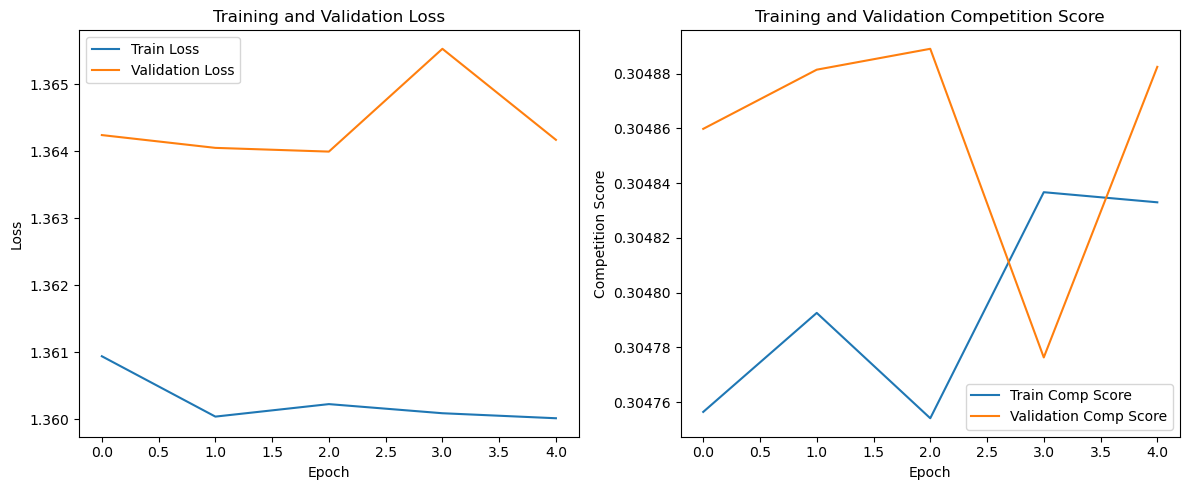

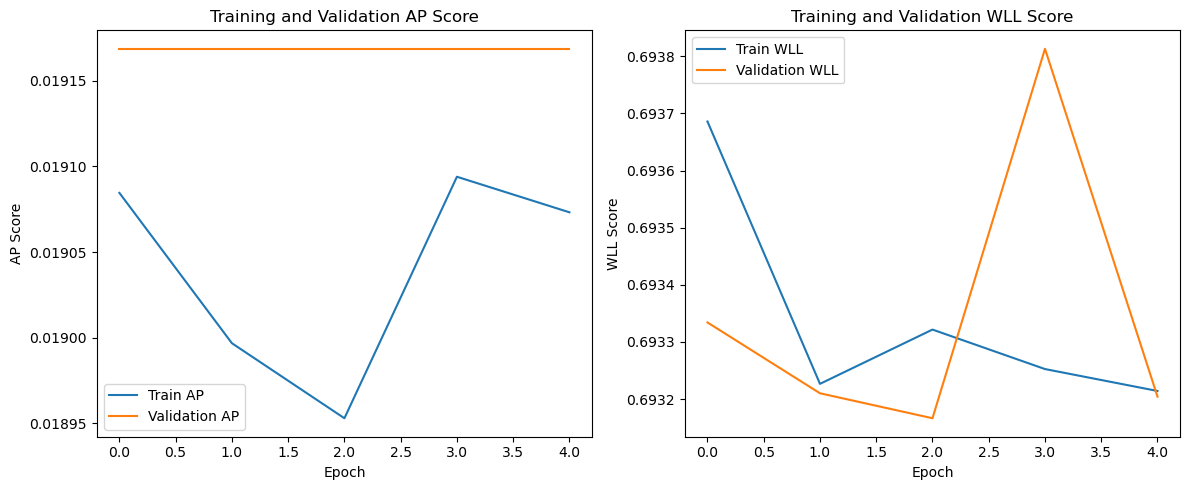

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_comp_scores'], label='Train Comp Score')
plt.plot(history['val_comp_scores'], label='Validation Comp Score')
plt.xlabel('Epoch')
plt.ylabel('Competition Score')
plt.title('Training and Validation Competition Score')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_ap_scores'], label='Train AP')
plt.plot(history['val_ap_scores'], label='Validation AP')
plt.xlabel('Epoch')
plt.ylabel('AP Score')
plt.title('Training and Validation AP Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_wll_scores'], label='Train WLL')
plt.plot(history['val_wll_scores'], label='Validation WLL')
plt.xlabel('Epoch')
plt.ylabel('WLL Score')
plt.title('Training and Validation WLL Score')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
import numpy as np

initial_missing_values = test.isnull().sum().sum()
if initial_missing_values > 0:
    print(f"Initial missing values in test set: {initial_missing_values}")
    test.fillna(0, inplace=True)
    remaining_missing_values = test.isnull().sum().sum()
    print(f"Remaining missing values in test set after filling with 0: {remaining_missing_values}")


test_numeric_cols = test.select_dtypes(include=[np.number])
test_inf_values = np.isinf(test_numeric_cols.to_numpy()).sum()
if test_inf_values > 0:
    print(f"Infinite values found in test set: {test_inf_values}")
    inf_cols_test = test_numeric_cols.columns[np.any(np.isinf(test_numeric_cols.to_numpy()), axis=0)]
    print(f"Columns with infinite values in test set: {inf_cols_test.tolist()}")
    # Handle infinite values if necessary, e.g., replace with NaN or a large number
    # test.replace([np.inf, -np.inf], np.nan, inplace=True) # Example replacement

empty_seq_count = test['seq'].astype(str).apply(lambda x: not bool(x.strip())).sum()
if empty_seq_count > 0:
    print(f"Empty 'seq' strings found in test set: {empty_seq_count}")

Initial missing values in test set: 173057
Remaining missing values in test set after filling with 0: 0


In [13]:
# model = ModifiedModel(
#         vocab_sizes=vocab_sizes,
#         embedding_dims=embedding_dims,
#         numerical_dim=len(numerical_cols),
#         lstm_hidden_dims = CFG['lstm_hidden_dims'],
#         lstm_layers = CFG['lstm_layers'],
#         transformer_n_heads=CFG['transformer_n_heads'],
#         transformer_n_layers=CFG['transformer_n_layers'],
#         n_dropout=CFG['n_dropout'],
#     ).to(device)

# model.load_state_dict(torch.load('./T2G_simple_best_model.pth'))

In [14]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

test_dataset = ClickDataset(test, categorical_cols, numerical_cols, seq_col, has_target=False)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, collate_fn=collate_fn_infer, num_workers=2)

model.eval()
outs = []
with torch.no_grad():
    for cat_features, num_features, seqs_padded, seq_lengths in tqdm(test_loader, desc="Inference"):
        cat_features, num_features, seqs_padded, seq_lengths = cat_features.to(device), num_features.to(device), seqs_padded.to(device), seq_lengths.to(device)
        logits = model(cat_features, num_features, seqs_padded, seq_lengths)
        predictions = torch.sigmoid(logits).cpu()
        outs.append(predictions)

test_preds = torch.cat(outs).numpy()

submit = pd.read_csv('./sample_submission.csv')
submit['clicked'] = test_preds
submit.to_csv('./T2G_simple_submission.csv', index=False)

Inference: 100%|██████████| 1492/1492 [03:34<00:00,  6.94it/s]


In [15]:
import pandas as pd
submit_df = pd.read_csv('./T2G_simple_submission.csv')
missing_values_count = submit_df['clicked'].isnull().sum()
total_missing_all_cols = submit_df.isnull().sum().sum()
print(f"Missing values in 'clicked' column: {missing_values_count}")
print(f"Total missing values in all columns: {total_missing_all_cols}")

Missing values in 'clicked' column: 0
Total missing values in all columns: 0
